In [30]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from scipy.optimize import curve_fit
from astropy import  convolution


DEIMOS_DATA = '/Users/tac1998/thesis/'
#DEIMOS_REDUX = '/Users/mgeha/Projects/DEIMOS/'
#_SPEED_OF_LIGHT =astropy.constants.c.to_value('km/s') 

In [31]:
# Read in sky line wavelengths
skylinefile = DEIMOS_DATA + '/sky_single_mg.dat'
sky_lines = pd.read_csv(skylinefile, sep='\s+')

In [32]:
wavel = sky_lines['Wave']

In [33]:
path_1 = DEIMOS_DATA + '/dra1_exp2/*.dat'
files_1 = glob.glob(path_1)

folder_1 = []

for name in files_1:
    df = pd.read_csv(name, sep='\s+')
    df['S/N'] = df['FLUX'] * np.sqrt(df['IVAR'])
    folder_1.append(df)

/Users/tac1998/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


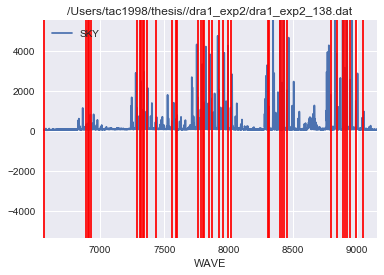

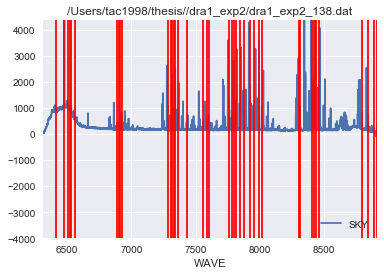

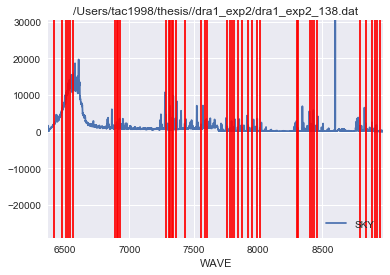

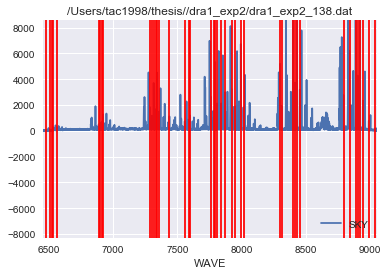

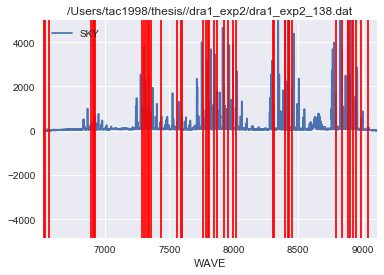

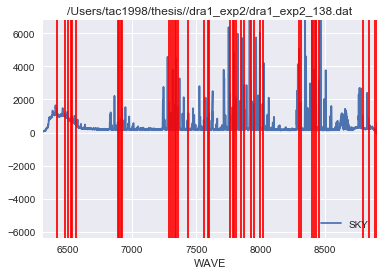

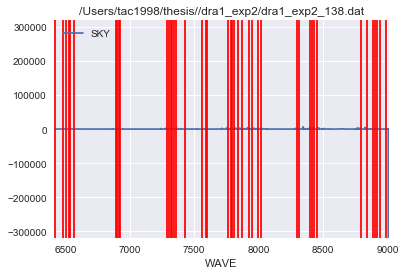

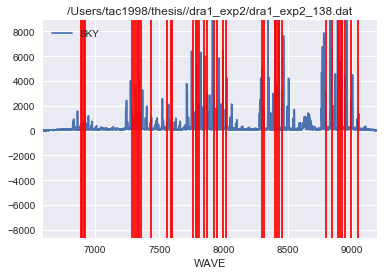

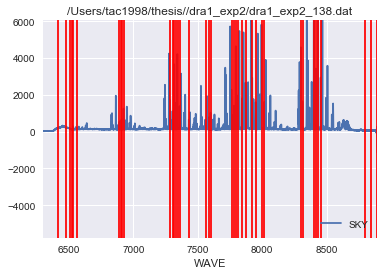

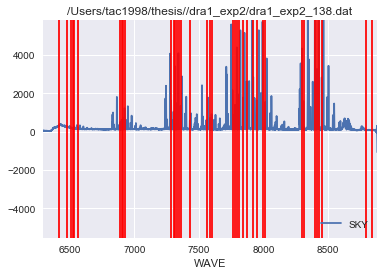

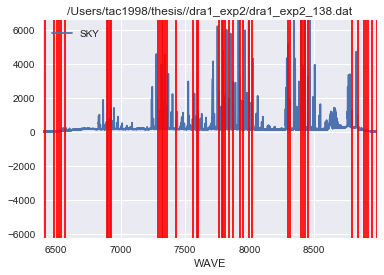

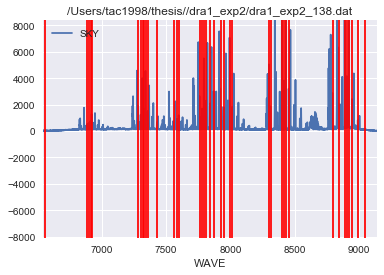

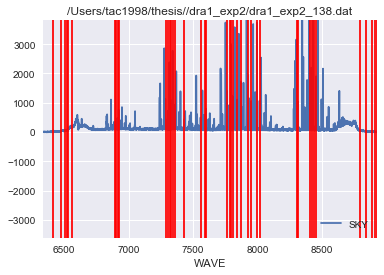

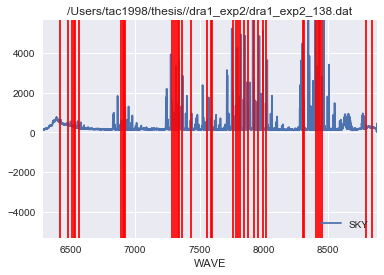

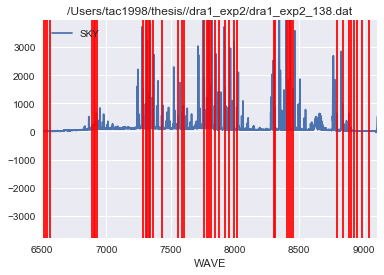

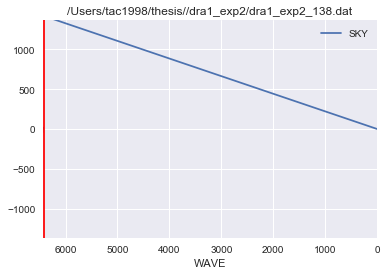

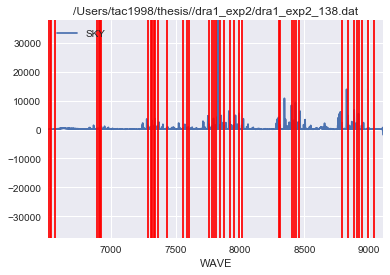

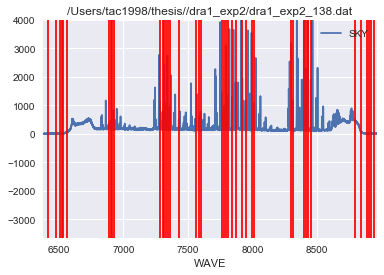

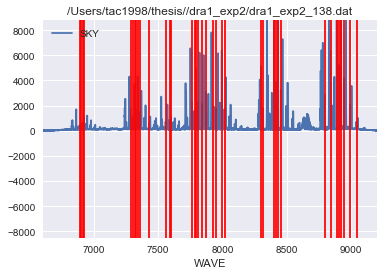

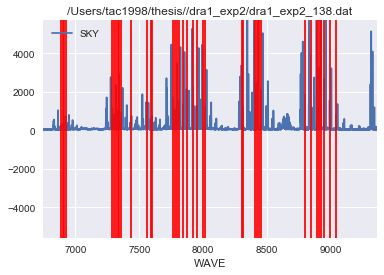

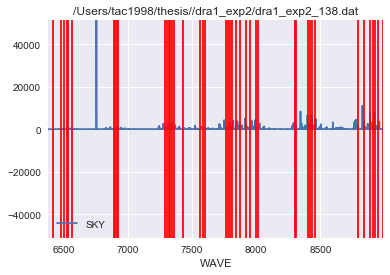

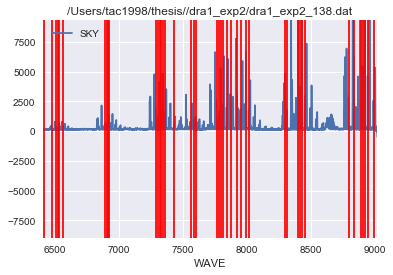

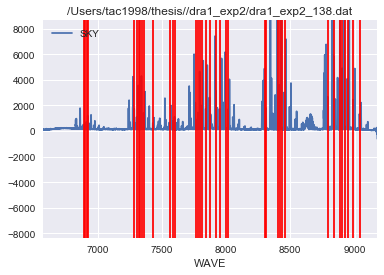

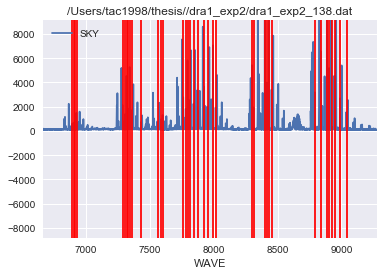

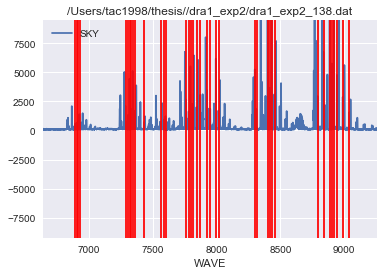

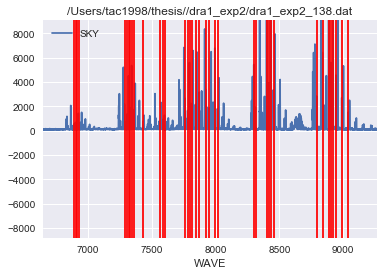

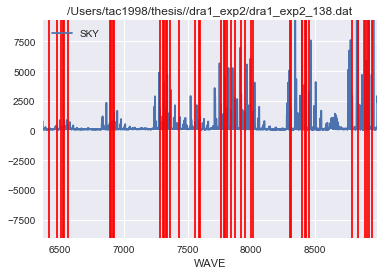

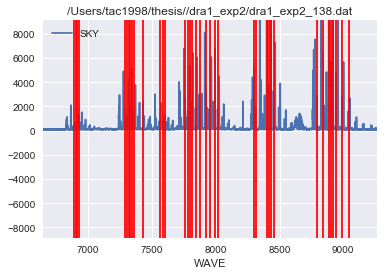

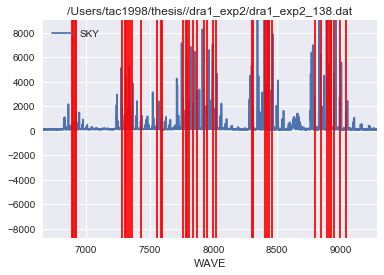

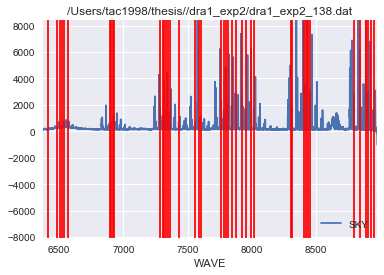

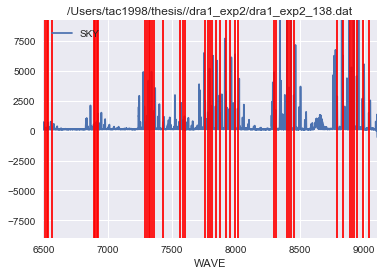

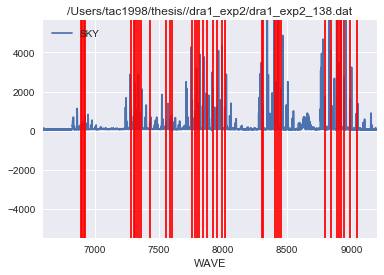

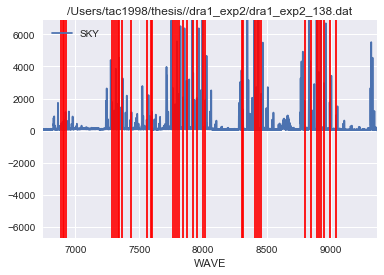

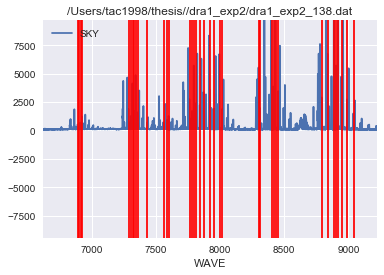

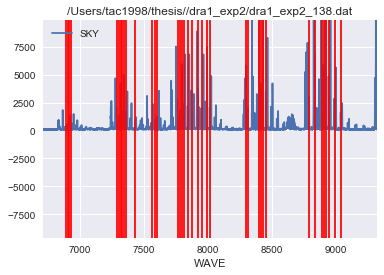

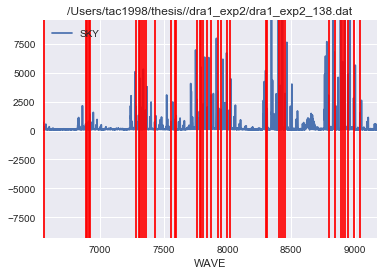

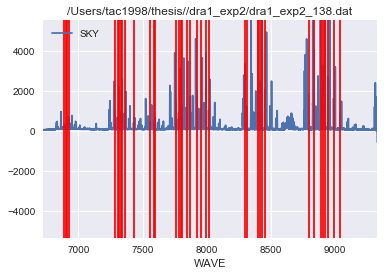

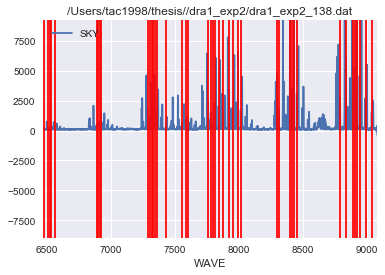

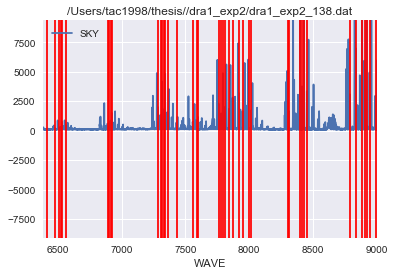

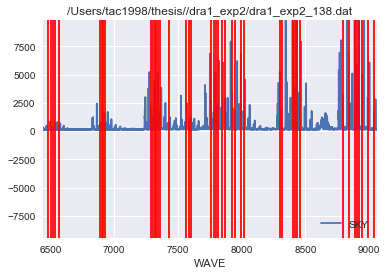

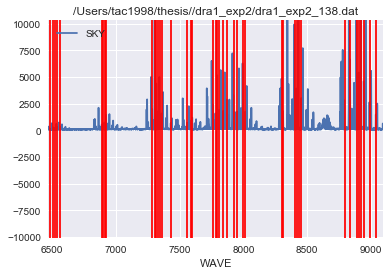

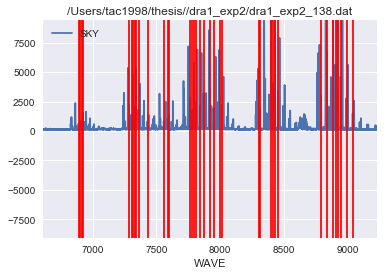

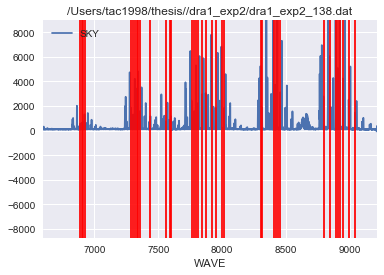

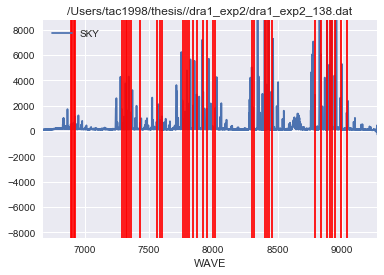

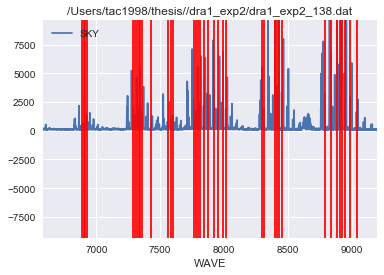

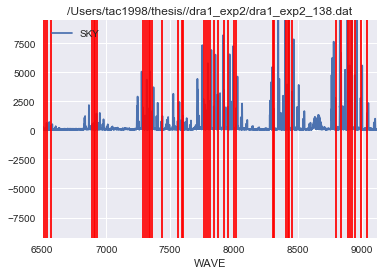

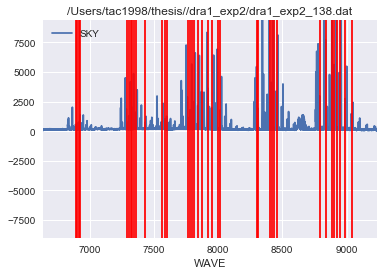

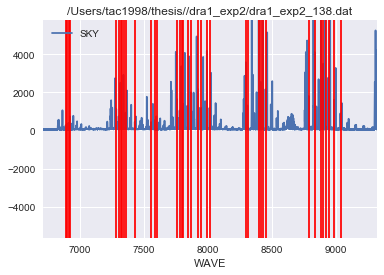

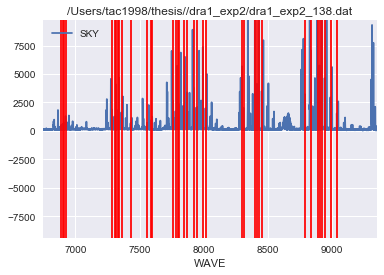

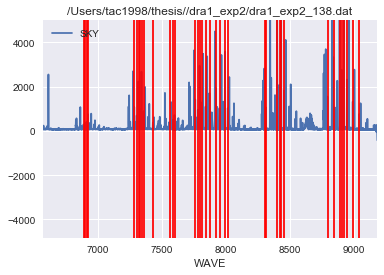

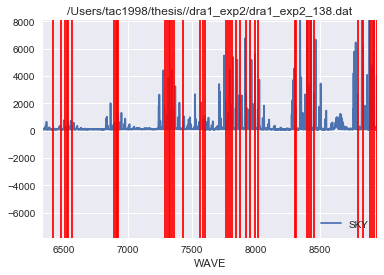

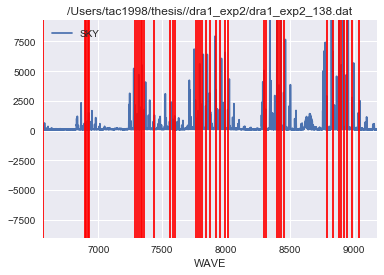

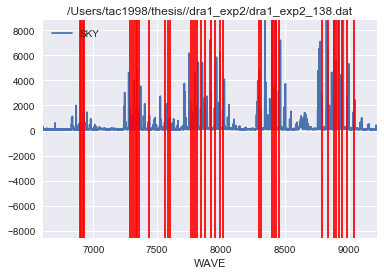

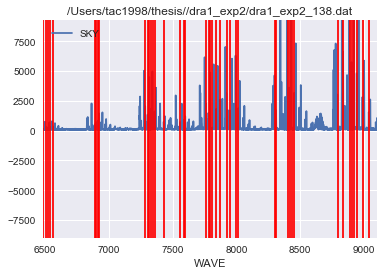

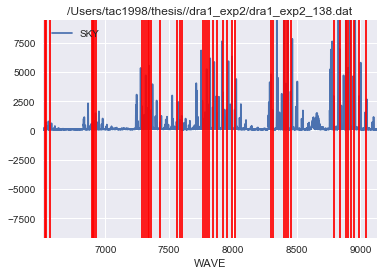

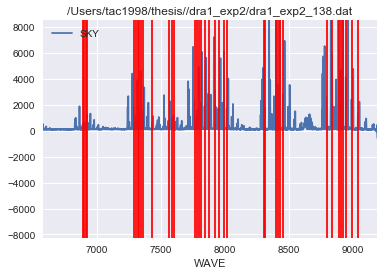

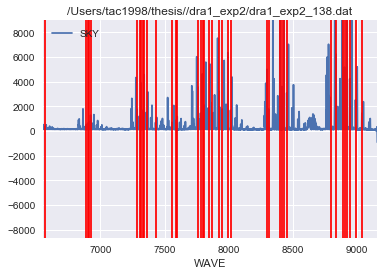

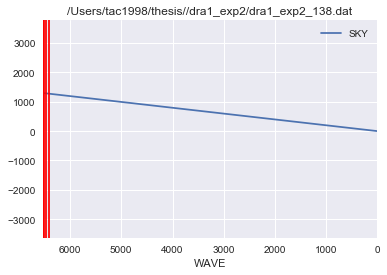

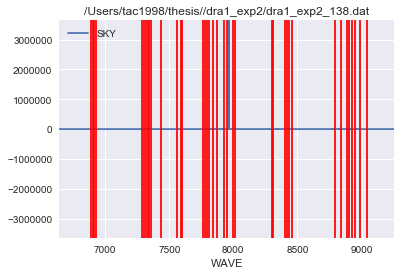

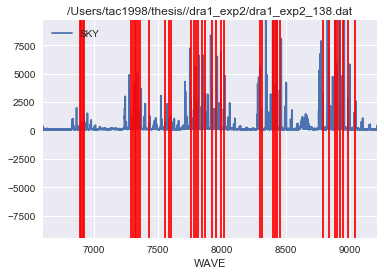

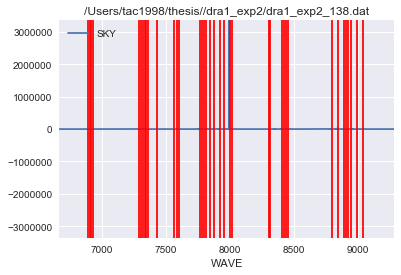

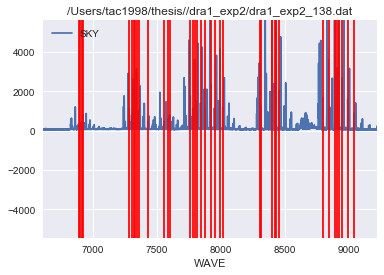

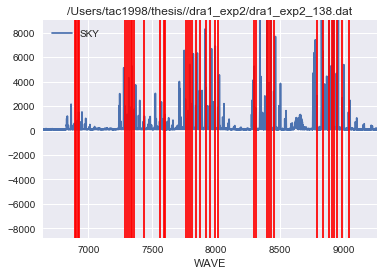

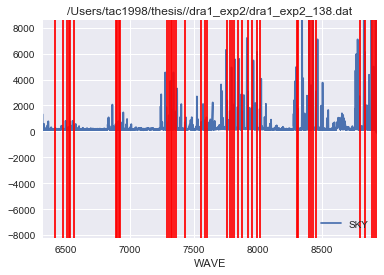

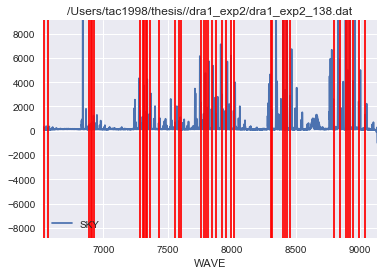

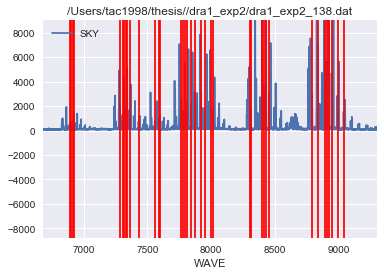

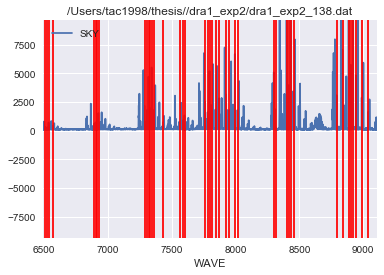

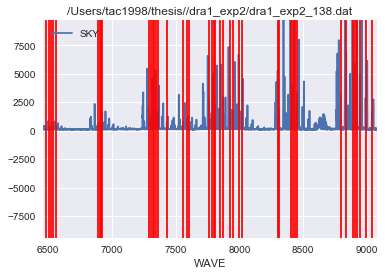

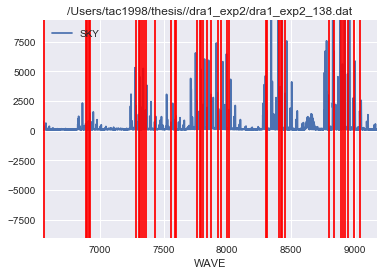

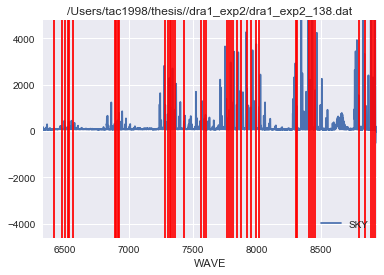

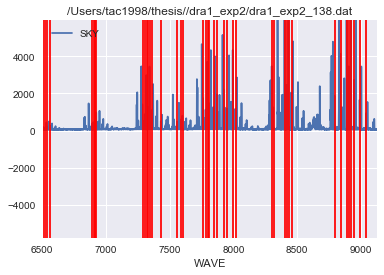

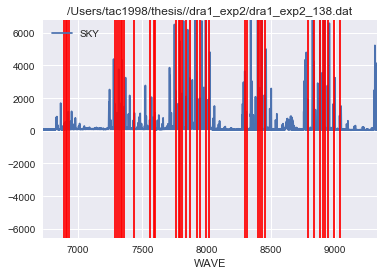

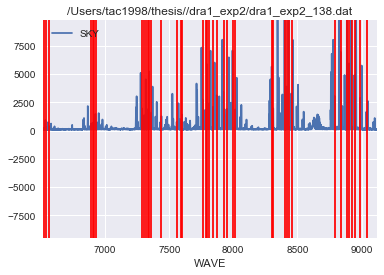

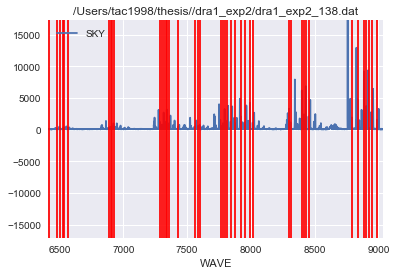

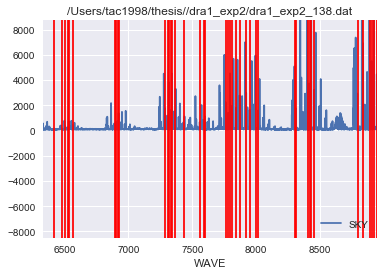

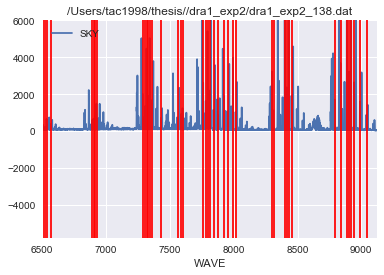

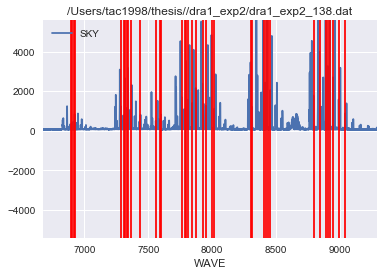

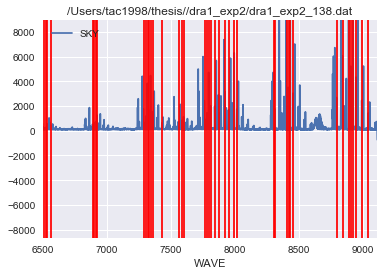

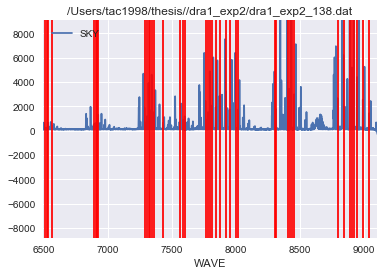

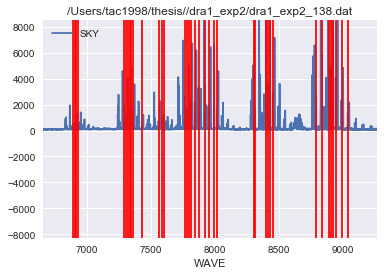

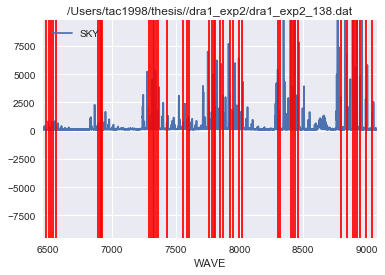

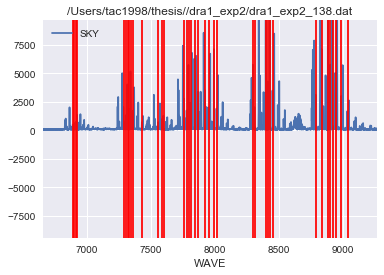

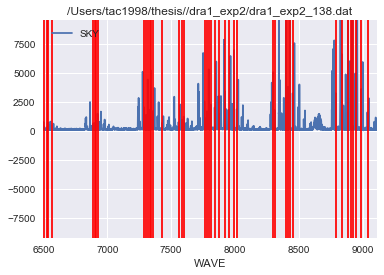

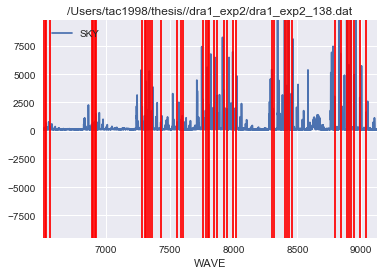

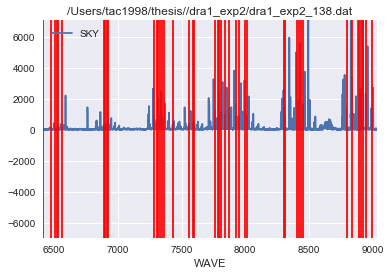

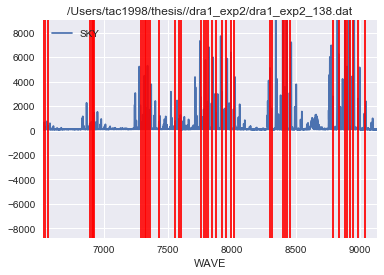

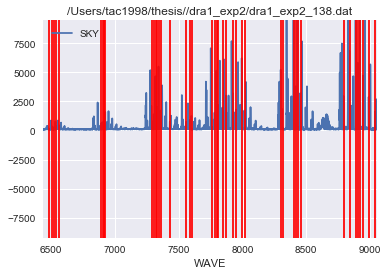

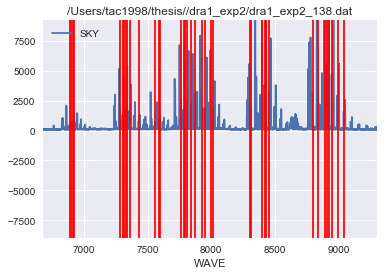

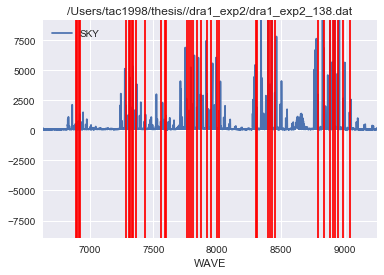

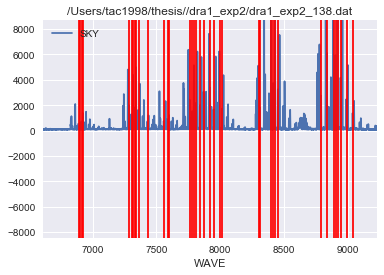

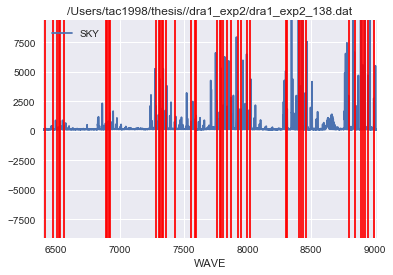

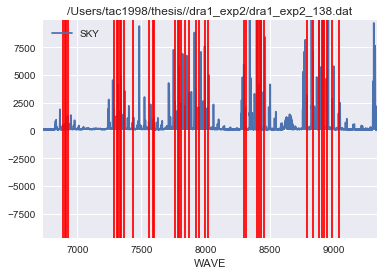

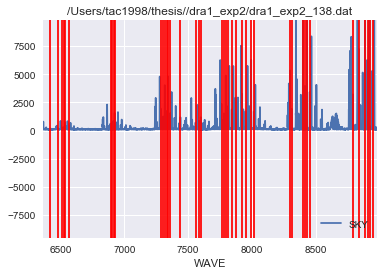

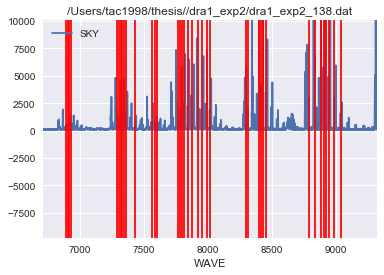

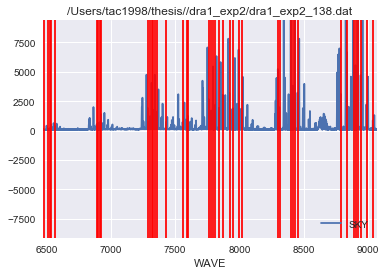

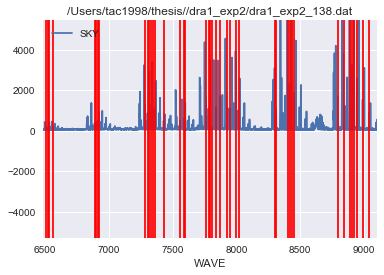

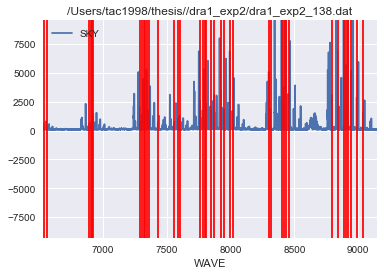

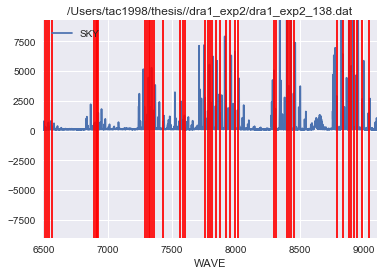

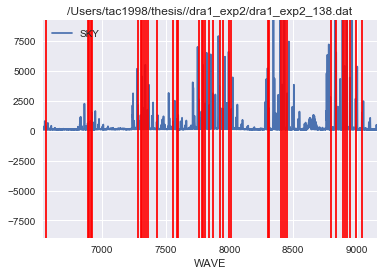

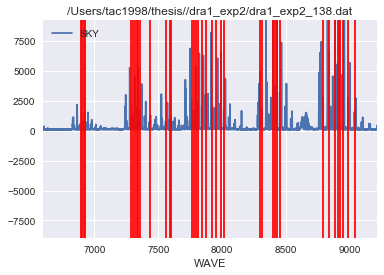

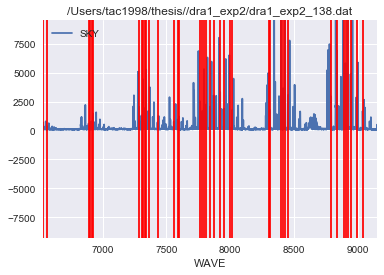

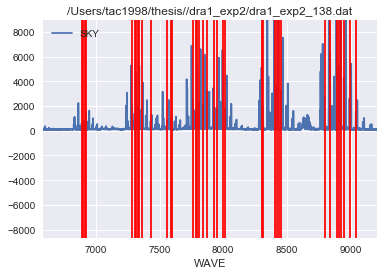

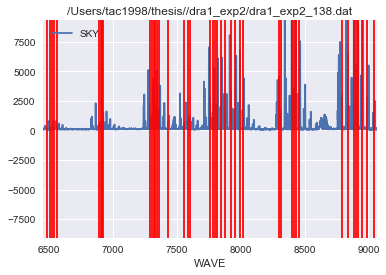

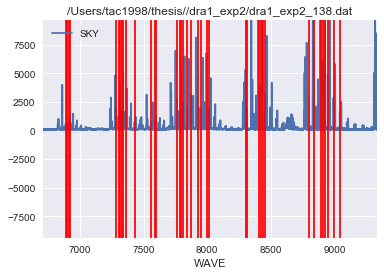

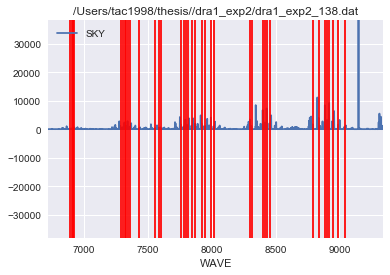

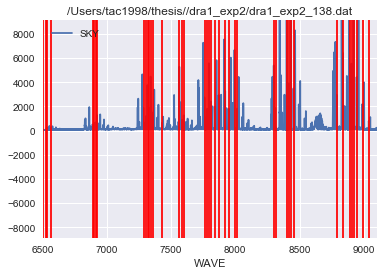

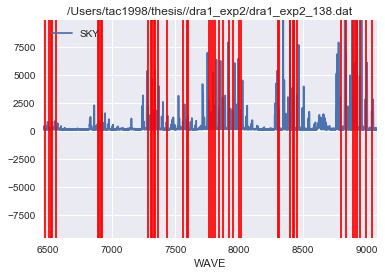

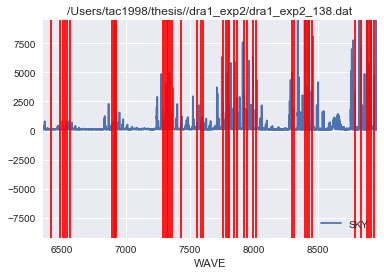

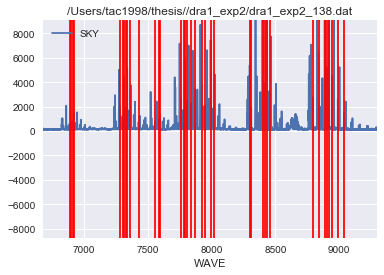

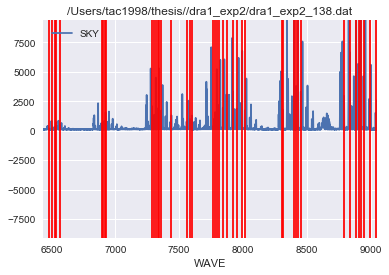

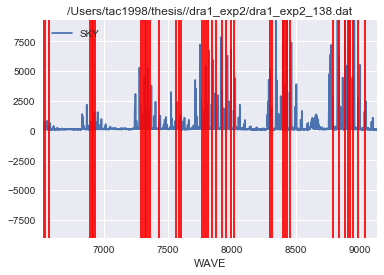

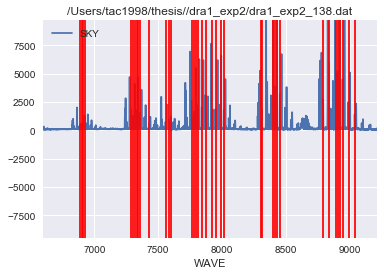

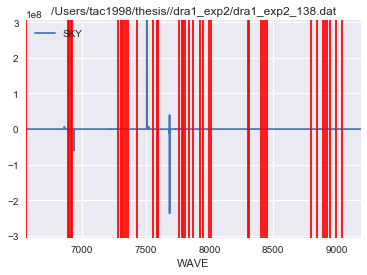

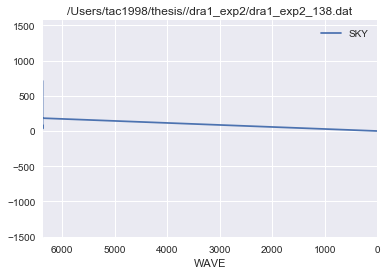

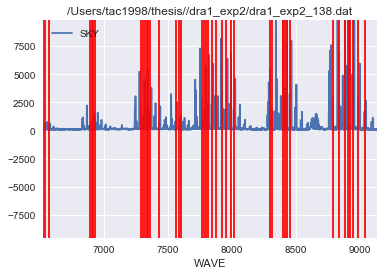

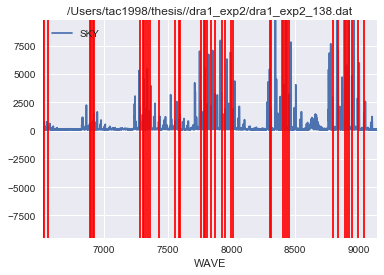

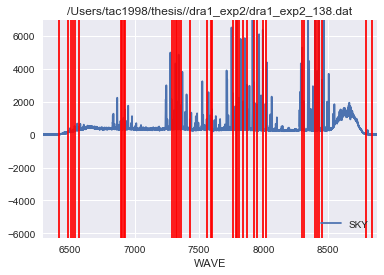

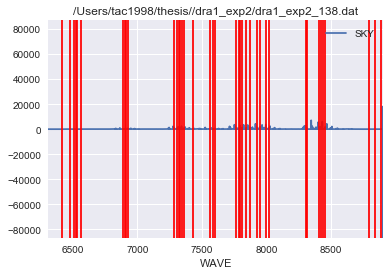

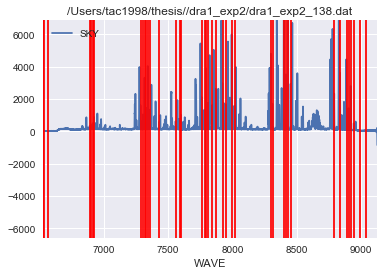

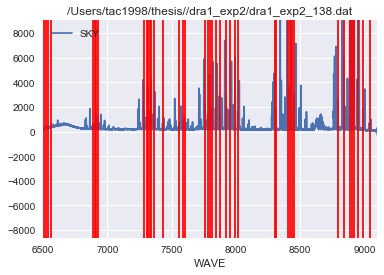

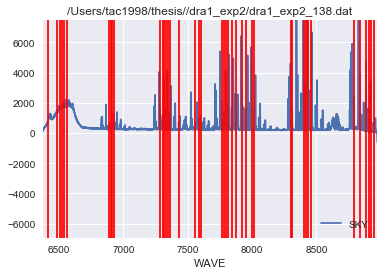

In [122]:
for file in folder_1:
    med = file['SKY'].median()
    std = file['SKY'].std()
    file.plot(x='WAVE', y='SKY', title=name, ylim=[med - 10*std, med + 10*std])
    for w in wavel:
        plt.axvline(x=w, color='red')

# Try out plotting wavelength & residuals for just one slit

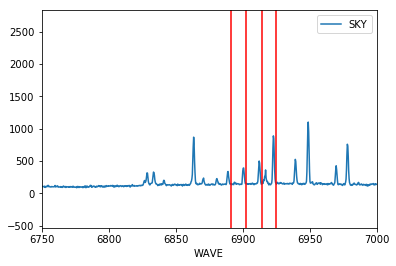

In [5]:
file_name = DEIMOS_DATA + '/dra1_exp2/dra1_exp2_129.dat'
one_df = pd.read_csv(file_name, sep='\s+')
med = one_df['SKY'].median()
std = one_df['SKY'].std()

one_df.plot(x='WAVE', y='SKY', xlim=[6750,7000], ylim=[med - (std),med + (std*4)])
for w in wavel:
    plt.axvline(x=w, color='red')

In [45]:
# Create a DataFrame with the observed wavelengths in one column and the difference between that wavelength and
# each skyline wavelengths in the following columns

difference = pd.DataFrame(one_df['WAVE'])
for w in wavel:
    difference[w] = one_df['WAVE'].sub(w, axis=0)
    
# Make the DataFrame into the absolute values of the differences. Then extract the indices of the minimum
# differences and put into a list

abs_difference = difference.abs()

min_indices = []
for w in wavel:
    index = abs_difference[w].idxmin() 
    min_indices.append(index)

# Iterate through all indicies and get the observed wavelength of the minimum differences

obs_wavelengths = []
obs_intensities = []
for m in min_indices:
    obs = one_df.iloc[m][0]
    intensity = one_df.iloc[m][3]
    obs_wavelengths.append(obs)
    obs_intensities.append(intensity)
    
# Join the observed wavelengths onto the original sky lines Data Frame and re-calculate the residuals

temp_skylines = pd.DataFrame(sky_lines['Wave'])
temp_skylines['Obs'] = obs_wavelengths
temp_skylines['Residual'] = temp_skylines['Wave'].sub(temp_skylines['Obs'], axis=0)
temp_skylines = temp_skylines.loc[abs(temp_skylines['Residual']) < 1]

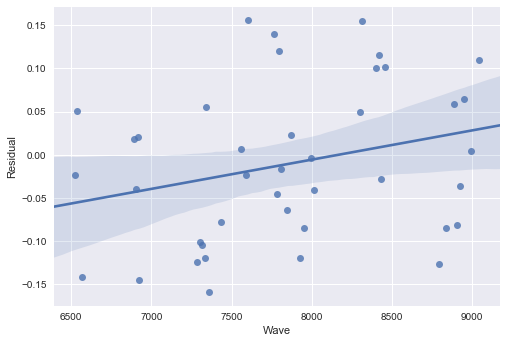

In [9]:
import seaborn as sns

sns.regplot(x=temp_skylines['Wave'], y=temp_skylines['Residual'], data=sky_lines);

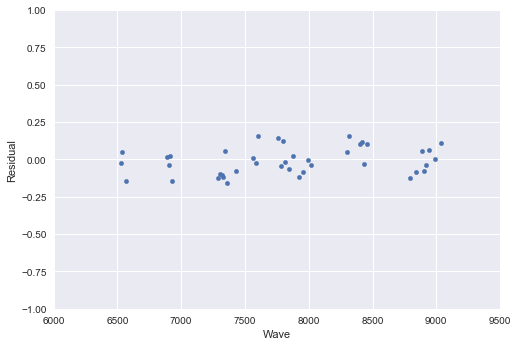

In [11]:
temp_skylines.plot.scatter(x='Wave', y='Residual', xlim=[6000,9500], ylim=[-1,1])

# Fitting a gaussian - for our one slit (IN PROGRESS)

In [140]:
from scipy.optimize import curve_fit

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

In [141]:
def gauss_guess(x,y):
    norm = np.median(np.percentile(y,50))
    w=np.mean(x)
    N_guess   = np.max(y) - np.min(y)
    sig_guess = 0.5
    p0 = [norm,N_guess,w,sig_guess]

    return p0

In [148]:
guess = []
sigma = 0.5
for i in range(len(obs_wavelengths)):
    one_guess = obs_wavelengths[i], obs_intensities[i], sigma
    guess.append(one_guess)

In [150]:
popt, pcov = curve_fit(func, obs_wavelengths, obs_intensities, p0=guess)
fit = func(obs_wavelengths, *popt)

TypeError: Improper input: N=132 must not exceed M=44

# Get wavelength v. residual plots for both masks

In [57]:
slit_dfs = []

for file in folder_1:
    
    # Create a DataFrame with the observed wavelengths in one column and the difference between that wavelength and
    # each skyline wavelengths in the following columns
    
    difference = pd.DataFrame(file['WAVE'])
    for w in wavel:
        difference[w] = file['WAVE'].sub(w, axis=0)

    # Make the DataFrame into the absolute values of the differences. Then extract the indices of the minimum
    #differences and put into a list

    abs_difference = difference.abs()

    min_indices = []
    for w in wavel:
        index = abs_difference[w].idxmin() 
        min_indices.append(index)

    # Iterate through all indicies and get the observed wavelength of the minimum differences

    obs_wavelengths = []
    obs_intensities = []
    for m in min_indices:
        obs = file.iloc[m][0]
        intensity = file.iloc[m][3]
        obs_wavelengths.append(obs)
        obs_intensities.append(intensity)
    
    # Join the observed wavelengths onto the original sky lines Data Frame and re-calculate the residuals

    temp_skylines = pd.DataFrame(sky_lines['Wave'])
    temp_skylines['Obs'] = obs_wavelengths
    temp_skylines['Residual'] = temp_skylines['Wave'].sub(temp_skylines['Obs'], axis=0)
    temp_skylines = temp_skylines.loc[abs(temp_skylines['Residual']) < 1]
    
    slit_dfs.append(temp_skylines)

In [58]:
# merge all dataframes together
from functools import reduce

slits_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Wave'],
                                            how='left'), slit_dfs)

In [50]:
cols = [c for c in slits_merged.columns if c[:3] == 'Res']
residuals_merged = slits_merged[cols]

In [51]:
median_difference = residuals_merged.median(axis=1)

In [52]:
sky_lines['Folder_1_Residuals'] = median_difference

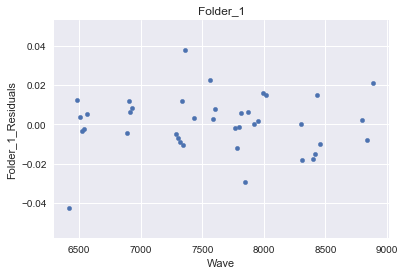

In [74]:
sky_lines.plot.scatter(x='Wave', y='Folder_1_Residuals', title='Folder_1')

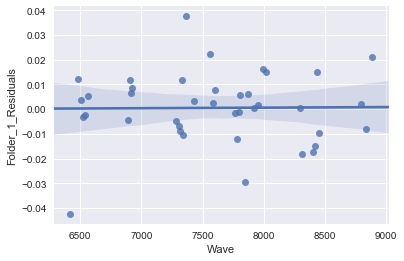

In [76]:
sns.regplot(x=sky_lines['Wave'], y=sky_lines['Folder_1_Residuals'], data=sky_lines);

In [59]:
path_2 = DEIMOS_DATA + '/uss-1/*.dat'
files_2 = glob.glob(path_2)

folder_2 = []

for name in files_2:
    df = pd.read_csv(name, sep='\s+')
    df['S/N'] = df['FLUX'] * np.sqrt(df['IVAR'])
    folder_2.append(df)

In [60]:
slit_dfs2 = []

for file in folder_2:
    
    # Create a DataFrame with the observed wavelengths in one column and the difference between that wavelength and
    # each skyline wavelengths in the following columns
    
    difference = pd.DataFrame(file['WAVE'])
    for w in wavel:
        difference[w] = file['WAVE'].sub(w, axis=0)

    # Make the DataFrame into the absolute values of the differences. Then extract the indices of the minimum
    #differences and put into a list

    abs_difference = difference.abs()

    min_indices = []
    for w in wavel:
        index = abs_difference[w].idxmin() 
        min_indices.append(index)

    # Iterate through all indicies and get the observed wavelength of the minimum differences

    obs_wavelengths = []
    obs_intensities = []
    for m in min_indices:
        obs = file.iloc[m][0]
        intensity = file.iloc[m][3]
        obs_wavelengths.append(obs)
        obs_intensities.append(intensity)
    
    # Join the observed wavelengths onto the original sky lines Data Frame and re-calculate the residuals

    temp_skylines = pd.DataFrame(sky_lines['Wave'])
    temp_skylines['Obs'] = obs_wavelengths
    temp_skylines['Residual'] = temp_skylines['Wave'].sub(temp_skylines['Obs'], axis=0)
    temp_skylines = temp_skylines.loc[abs(temp_skylines['Residual']) < 1]
    
    slit_dfs2.append(temp_skylines)

In [67]:
# merge all dataframes together
from functools import reduce

slits_merged2 = reduce(lambda  left,right: pd.merge(left,right,on=['Wave'],
                                            how='left'), slit_dfs2)

In [68]:
cols2 = [c for c in slits_merged2.columns if c[:3] == 'Res']
residuals_merged2 = slits_merged2[cols2]

In [69]:
median_difference2 = residuals_merged2.median(axis=1)

In [70]:
sky_lines['Folder_2_Residuals'] = median_difference2

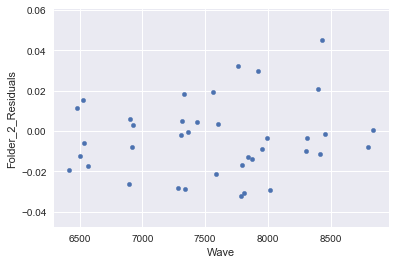

In [71]:
sky_lines.plot.scatter(x='Wave', y='Folder_2_Residuals')

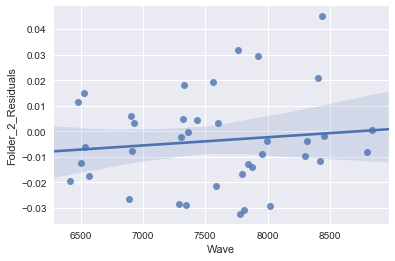

In [72]:
sns.regplot(x=sky_lines['Wave'], y=sky_lines['Folder_2_Residuals'], data=sky_lines);